In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import model_selection,preprocessing
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,LabelBinarizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 
from sklearn.naive_bayes import MultinomialNB
from gensim.sklearn_api import D2VTransformer
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import AdaBoostClassifier
from scipy import stats
from scipy.stats import randint
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from mlinsights.mlmodel.sklearn_text import TraceableTfidfVectorizer
import plotly
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



/home/srinivas/mypython/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv("newsdatafinal.csv")


In [173]:
len(df)

6247

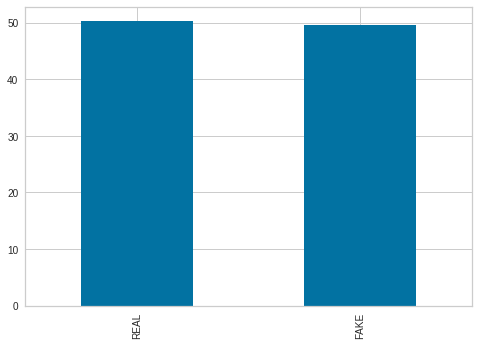

In [72]:
((pd.value_counts(df['label'],normalize=True))*100).plot.bar()


In [40]:
def stem_text(word_list):  #Lemmatize text
    new_list = []
    for word in word_list:
        wl = PorterStemmer()
        rootword=wl.stem(word)
        new_list.append(rootword)
    return new_list


def remove_stopwords(row):     #Remove Stopwords from text
    tokens = word_tokenize(row)
    filtered_word = [word for word in tokens if not word in stop_words]
    #stemmed_text = stem_text(filtered_word)
    return filtered_word


def make_string(row):      #Convert list into string
    new = ''
    for word in row:
        new = new + word
        new = new + ' '
    return new


def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

df['statement_clean'] = ''
df['statement_clean'] = df['news'].apply(lambda x: x.lower())
df['statement_clean'] = df['statement_clean'].map(lambda x:clean_text(x))
stop_words = set(stopwords.words('english'))
df['statement_clean'] = df['statement_clean'].apply(remove_stopwords)
df['statement_clean'] = df['statement_clean'].apply(make_string)
df['statement_clean'].replace(to_replace = '[^\w\s]',value='',inplace = True,regex = True )  #Remove punctuation
df['statement_clean'].replace(to_replace = '[\d]',value='',inplace = True,regex = True )     #Remove digits
df['statement_clean'] = df['statement_clean'].apply(lambda x:" ".join(x.split()))            #Remove duplicate white spaces
df['statement_clean'] = df['statement_clean'].apply(lambda x:" ".join(word for word in x.split(' ') if len(word) > 3))   #Remove single letter words
print(df['statement_clean'])

0       daniel greenfield shillman journalism fellow f...
1       google pinterest digg linkedin reddit stumbleu...
2       secretary state john kerry said monday stop pa...
3       kaydee king kaydeeking november lesson tonight...
4       primary york front runners hillary clinton don...
                              ...                        
6242    state department told republican national comm...
6243    stand plutocratic pentagon posted wikimedia te...
6244    anti trump protesters tools oligarchy reform a...
6245    addis ababa ethiopia president obama convened ...
6246    bush suddenly attacking trump matters bush pul...
Name: statement_clean, Length: 6247, dtype: object


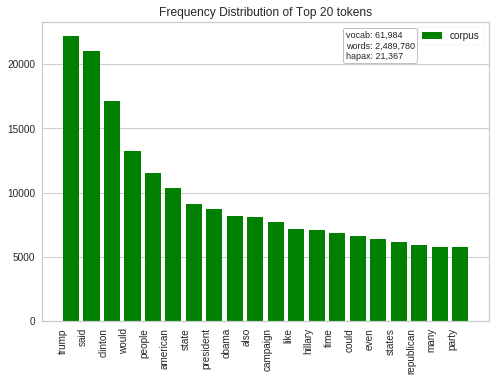

In [46]:
from yellowbrick.text import FreqDistVisualizer

tfidf = CountVectorizer()
doc = tfidf.fit_transform(df['statement_clean'])
features = tfidf.get_feature_names()
visualizer = FreqDistVisualizer(features=features,orient='v',n=20,color='green')
visualizer.fit(doc)
visualizer.poof()

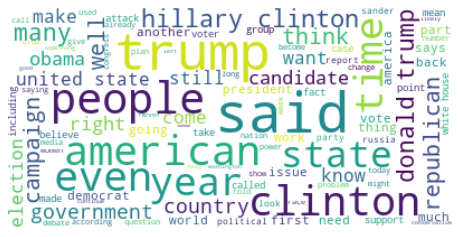

In [51]:


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df['statement_clean']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


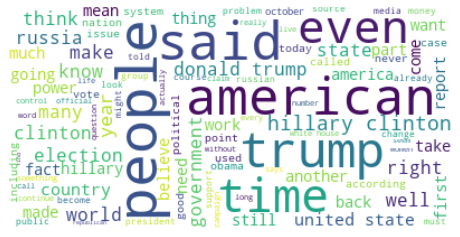

In [54]:
fake_cloud = df[df['label']=='FAKE']
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(fake_cloud['statement_clean']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

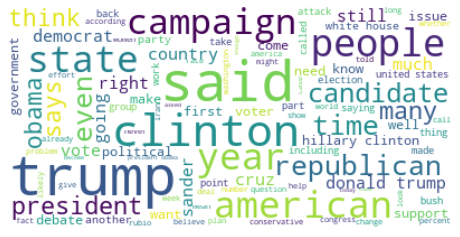

In [56]:
true_cloud = df[df['label']=='REAL']
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(true_cloud['statement_clean']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [110]:
overall_length = len(df[df['statement_clean'].str.contains('obama')])
print(overall_length)
trump_real = len(true_cloud[true_cloud['statement_clean'].str.contains('obama')])
print(trump_real)
trump_fake = len(fake_cloud[fake_cloud['statement_clean'].str.contains('obama')])
print(trump_fake)


trump_dict = {}
real_news = (trump_real/overall_length)*100
fake_news = (trump_fake/overall_length)*100
trump_dict['Real News'] = real_news
trump_dict['Fake News'] = fake_news
print(trump_dict)

trump_series = pd.Series(trump_dict)

2119
1521
598
{'Real News': 71.77914110429448, 'Fake News': 28.22085889570552}


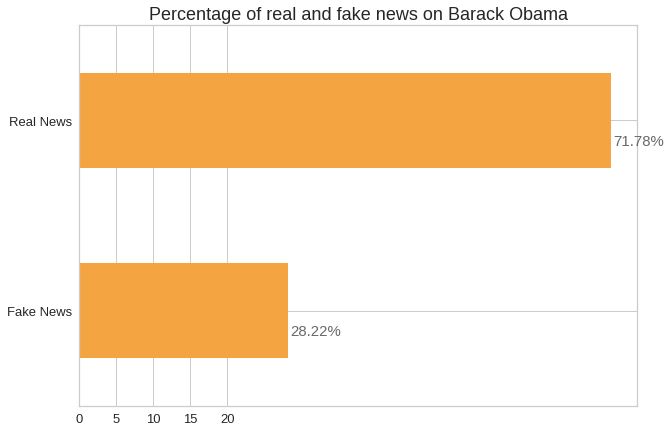

In [112]:
ax = trump_series.plot(kind='barh', figsize=(10,7),
                                        color='#f5a442', fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Percentage of real and fake news on Barack Obama", fontsize=18)
ax.set_xticks([0, 5, 10, 15, 20])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')
ax.invert_yaxis()


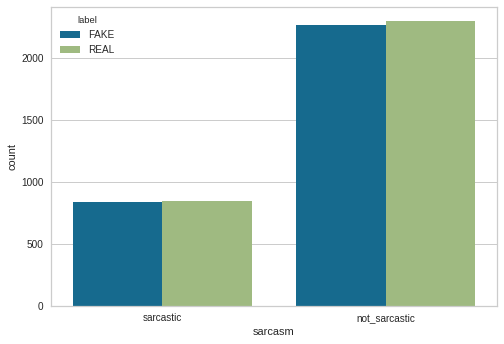

In [144]:

ax = sns.countplot(x='sarcasm',hue='label',data=df)


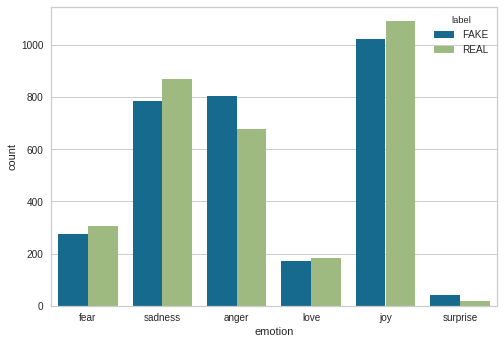

In [141]:
ax = sns.countplot(x='emotion',hue='label',data=df)

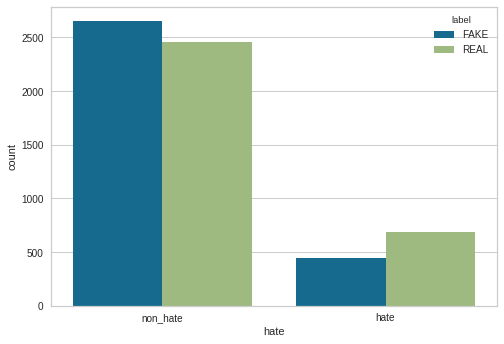

In [142]:
ax = sns.countplot(x='hate',hue='label',data=df)

In [5]:
df['statement_clean'] = df['statement_clean'].str.replace(r"http\S+", "",regex=True)


In [169]:
encoder = preprocessing.LabelEncoder()
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['statement_clean'],df['label'])

train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer()
#tfidf_vect.fit(df['statement_clean'])
xtrain_tfidf = tfidf_vect.fit_transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

In [172]:
xtrain_tfidf

<4685x54914 sparse matrix of type '<class 'numpy.float64'>'
	with 1203120 stored elements in Compressed Sparse Row format>

[('party', 'nomination', 'senate', 'convention', 'iowa', 'candidates', 'percent', 'kasich', 'debate', 'october', 'delegates', 'bush', 'obama', 'republicans', 'trump', 'republican', 'rubio', 'sanders', 'said', 'cruz'), (18.13390279522175, 18.276697979978017, 18.958902687199775, 19.135360205447977, 19.78967170352101, 19.843608499603167, 19.865754523264748, 20.688523681849738, 20.728997294309146, 20.98610476397725, 22.06999147259588, 24.513001863332953, 24.913128247522597, 25.21212189209918, 26.0759073453577, 27.95858273706154, 33.90110951209587, 39.380134429714516, 49.53035325483432, 49.59303391734274)]


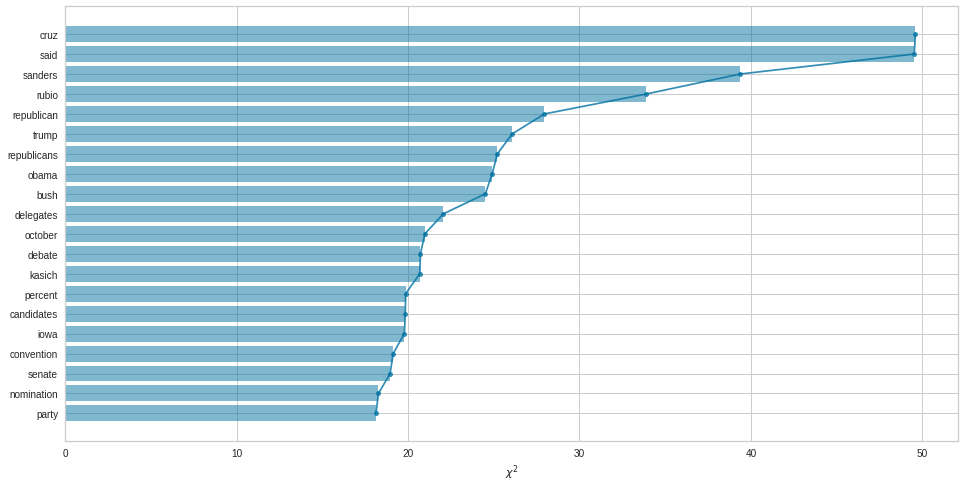

In [170]:
chi2score=chi2(xtrain_tfidf,train_y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf_vect.get_feature_names(), chi2score))
chi2_ = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2_[-20:]))
print(topchi2)
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show()

In [174]:

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df[['emotion','sarcasm','hate','statement_clean']],df['label'])



In [175]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [176]:
print(train_y)
print(valid_y)

[0 0 1 ... 0 1 1]
[1 1 0 ... 0 1 0]


In [177]:
type(valid_y)

numpy.ndarray

In [236]:
class ItemSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]
        

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(X.shape)
        print(X)
        print(type(X))
        print(self)
        self.shape = X.shape
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self

    


In [237]:
pipeline = Pipeline([

    ('union', FeatureUnion(
        transformer_list=[

          
            ('subject', Pipeline([
                ('selector', ItemSelector(key='statement_clean')),
                ('tfidf', TfidfVectorizer()),
                ('debug',Debug()),
                #('chi2', SelectKBest(chi2, k = 3500)),
            ])),

           
            ('cat1', Pipeline([
                ('selector', ItemSelector(key='hate')),
                ('encode', MyLabelBinarizer()),
                ('debug',Debug()),
            ])),

            ('cat2', Pipeline([
                ('selector', ItemSelector(key='emotion')),
                ('encode', MyLabelBinarizer()),
                ('debug',Debug()),
               
            ])),
            
            
         
                
               ('cat3', Pipeline([
                ('selector', ItemSelector(key='sarcasm')),
                 ('encode', MyLabelBinarizer()),
                  ('debug',Debug()),
               
            ])),

        ],

      
       
    )),
    
    
    ('debug',Debug()),
    ('clf',SGDClassifier()),
    

])

In [238]:
.pipeline.fit(train_x,train_y)




(4685, 55039)
  (0, 29767)	0.05470584743152658
  (0, 20094)	0.04169503304098434
  (0, 44280)	0.08366237311044494
  (0, 47331)	0.04773969256625439
  (0, 2833)	0.08057640426261532
  (0, 344)	0.06151547644978085
  (0, 37124)	0.05046798619644367
  (0, 22566)	0.04539161991004581
  (0, 9452)	0.05107003394247055
  (0, 43456)	0.033097691089578905
  (0, 31005)	0.03495965838142882
  (0, 6370)	0.04945352124722543
  (0, 37484)	0.032829357270678296
  (0, 11283)	0.0799124958604193
  (0, 47333)	0.04826843357005327
  (0, 504)	0.033878762565378806
  (0, 7834)	0.040969225954145545
  (0, 7849)	0.047552931334476696
  (0, 22772)	0.10755681539032896
  (0, 19997)	0.03360788435434519
  (0, 753)	0.056018053580535264
  (0, 762)	0.0687910150385694
  (0, 12548)	0.06027964296653691
  (0, 39701)	0.031257974884021086
  (0, 25314)	0.034062725770619875
  :	:
  (4684, 26453)	0.017414794568021575
  (4684, 33025)	0.013288774592267632
  (4684, 28562)	0.020708747256968134
  (4684, 49376)	0.02163221977390279
  (4684, 49554)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('subject',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='statement_clean')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
        

In [229]:
prediction = pipeline.predict(valid_x)

(1562, 55039)
<class 'scipy.sparse.csr.csr_matrix'>
Debug()
(1562, 1)
<class 'numpy.ndarray'>
Debug()
(1562, 6)
<class 'numpy.ndarray'>
Debug()
(1562, 1)
<class 'numpy.ndarray'>
Debug()
(1562, 55047)
<class 'scipy.sparse.csr.csr_matrix'>
Debug()


In [239]:
list(prediction)

[1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,


In [240]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results = confusion_matrix(valid_y, prediction)
print ('Accuracy Score :',accuracy_score(valid_y, prediction))
print ('Report : ')
print (classification_report(valid_y,prediction))
print(results)

Accuracy Score : 0.9340588988476313
Report : 
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       772
           1       0.95      0.92      0.93       790

    accuracy                           0.93      1562
   macro avg       0.93      0.93      0.93      1562
weighted avg       0.93      0.93      0.93      1562

[[732  40]
 [ 63 727]]


In [241]:
scores = cross_val_score(pipeline,df[['hate','emotion','sarcasm','statement_clean']],df['label'],cv=20)

(5933, 60737)
  (0, 41329)	0.030688652105020333
  (0, 52974)	0.019010784093070714
  (0, 44353)	0.05272367742202319
  (0, 19263)	0.03714196010101507
  (0, 5832)	0.03189965380242487
  (0, 47524)	0.02731809934195792
  (0, 26434)	0.024149700981625423
  (0, 39246)	0.01531408708428525
  (0, 50762)	0.03053732128302738
  (0, 17899)	0.022201691306259434
  (0, 13316)	0.032179540050124245
  (0, 16738)	0.022493897480859316
  (0, 52879)	0.03893843371782979
  (0, 26749)	0.04964583647781927
  (0, 44349)	0.03176390963831567
  (0, 18616)	0.030244389807702013
  (0, 51884)	0.03714196010101507
  (0, 26456)	0.0346151623559172
  (0, 22717)	0.03776144213487023
  (0, 42017)	0.022727526114912074
  (0, 53137)	0.039756569233305124
  (0, 4746)	0.027294818612484804
  (0, 7138)	0.023933504831653588
  (0, 37980)	0.0316308186252019
  (0, 39162)	0.0354856573439169
  :	:
  (5932, 36048)	0.0172277116804928
  (5932, 58345)	0.020308818895927394
  (5932, 10262)	0.02239645948292124
  (5932, 31231)	0.023560382594862532
  (59

(5933, 60730)
  (0, 16894)	0.02295819738696752
  (0, 6829)	0.022901228981361373
  (0, 106)	0.03419484945150199
  (0, 25325)	0.03413843014489487
  (0, 7294)	0.038840622122421176
  (0, 31063)	0.028300164854298104
  (0, 8713)	0.0258810080387463
  (0, 48951)	0.027151266431316785
  (0, 36433)	0.01691732111049688
  (0, 12609)	0.029048397486313764
  (0, 37227)	0.03062942074447633
  (0, 59872)	0.03791640795567752
  (0, 51130)	0.023050318916002503
  (0, 30350)	0.013764541304389522
  (0, 47324)	0.030264015312029616
  (0, 55990)	0.03516524034930619
  (0, 43487)	0.03549820153973593
  (0, 9788)	0.03244848280330904
  (0, 3753)	0.018593263137462023
  (0, 51304)	0.02531477354638951
  (0, 7997)	0.040299115469758374
  (0, 57529)	0.029947557925888695
  (0, 48095)	0.0232501831449122
  (0, 58643)	0.028349285095790693
  (0, 1597)	0.022304333536727332
  :	:
  (5932, 53106)	0.02243795507805061
  (5932, 39475)	0.025378238260938914
  (5932, 36468)	0.016524254627170446
  (5932, 29644)	0.01709353869418994
  (5932

(5934, 60814)
  (0, 16935)	0.02301338287498251
  (0, 6850)	0.022956598976812417
  (0, 106)	0.03419299496660622
  (0, 25367)	0.034082708340387874
  (0, 7312)	0.03870667511670936
  (0, 31080)	0.02834078558350237
  (0, 8734)	0.025734124626376188
  (0, 49004)	0.027263161837683837
  (0, 36474)	0.01698105014827924
  (0, 12629)	0.02902807195410806
  (0, 37261)	0.030744840242420655
  (0, 59963)	0.038101315694791194
  (0, 51188)	0.023116759506097782
  (0, 30359)	0.013733750147815658
  (0, 47384)	0.03025105849920684
  (0, 56065)	0.03540247586194603
  (0, 43528)	0.03533681770965445
  (0, 9809)	0.032431528474806
  (0, 3755)	0.018672203900535957
  (0, 51367)	0.02520148201414355
  (0, 8014)	0.04022918946752071
  (0, 57611)	0.02997056329272538
  (0, 48153)	0.023412124797249047
  (0, 58730)	0.02826839314916834
  (0, 1599)	0.02228691778672387
  :	:
  (5933, 53181)	0.02235571652864597
  (5933, 39516)	0.02535668241472093
  (5933, 36508)	0.016471151271153783
  (5933, 29665)	0.017065103953047518
  (5933, 4

(5934, 60743)
  (0, 16887)	0.022985585467885476
  (0, 6830)	0.02292874347451093
  (0, 104)	0.03400778585185878
  (0, 25345)	0.033899434718601164
  (0, 7294)	0.038621587969483014
  (0, 31042)	0.0284252132122083
  (0, 8707)	0.02572791951870168
  (0, 48959)	0.027500255153649834
  (0, 36426)	0.01697768556600911
  (0, 12596)	0.02893763440687616
  (0, 37225)	0.030780069981588772
  (0, 59886)	0.03773392290682593
  (0, 51121)	0.02313555821395643
  (0, 30333)	0.013724980165756434
  (0, 47331)	0.030248294093192605
  (0, 55987)	0.03539078116883737
  (0, 43491)	0.035592977393644566
  (0, 9779)	0.032274348237077005
  (0, 3747)	0.018625009500491316
  (0, 51299)	0.025068944116275946
  (0, 7988)	0.040140755445308825
  (0, 57538)	0.0297538676314008
  (0, 48104)	0.023372708052398477
  (0, 58657)	0.02830272865107299
  (0, 1599)	0.022293070776002646
  :	:
  (5933, 53103)	0.02234357529999606
  (5933, 39480)	0.025348392228190374
  (5933, 36461)	0.01643813505733374
  (5933, 29636)	0.017102847064567987
  (593

(5934, 60472)
  (0, 16812)	0.02308398674466247
  (0, 6801)	0.022912767134111705
  (0, 104)	0.03425639780779641
  (0, 25234)	0.034144519363159126
  (0, 7263)	0.03886539842639731
  (0, 30900)	0.02834921511788231
  (0, 8670)	0.02595334739350911
  (0, 48724)	0.027224510698079126
  (0, 36251)	0.016995835903193562
  (0, 12545)	0.029067470356979604
  (0, 37027)	0.030735384864420963
  (0, 59620)	0.03776344098765917
  (0, 50892)	0.023037919953072805
  (0, 30191)	0.013711222610393084
  (0, 47105)	0.03053303046776074
  (0, 55742)	0.03509360721610882
  (0, 43271)	0.035418466282359035
  (0, 9739)	0.03229959546150301
  (0, 3744)	0.018713771470469567
  (0, 51072)	0.025103927069948805
  (0, 7958)	0.04043815747088542
  (0, 57280)	0.0299893628845471
  (0, 47874)	0.023342881072817484
  (0, 58391)	0.0283006066905839
  (0, 1591)	0.022272279559464803
  :	:
  (5933, 52875)	0.022443908503181696
  (5933, 39271)	0.025472161470828952
  (5933, 36284)	0.016474488869725745
  (5933, 29495)	0.01710267763372782
  (593

(5935, 60599)
  (0, 16858)	0.02305998409700106
  (0, 6775)	0.022979922486550727
  (0, 94)	0.03427153789698242
  (0, 25296)	0.03399499011287997
  (0, 7245)	0.03888241569567245
  (0, 30974)	0.028361949295972626
  (0, 8670)	0.02579353855406715
  (0, 48840)	0.02729946334304975
  (0, 36333)	0.016936053530890244
  (0, 12570)	0.029080497070164902
  (0, 37125)	0.03078340271318506
  (0, 59753)	0.03825985881448217
  (0, 51012)	0.023025560604784428
  (0, 30259)	0.013693575647387378
  (0, 47223)	0.030317597038195022
  (0, 55868)	0.03523729299608392
  (0, 43370)	0.03563651647814305
  (0, 9742)	0.03227133382318545
  (0, 3709)	0.018660675124802985
  (0, 51190)	0.025084615846731818
  (0, 7955)	0.04045581530244459
  (0, 57400)	0.02991099286937011
  (0, 47988)	0.023389643148089802
  (0, 58523)	0.02848500764889721
  (0, 1576)	0.022377400545062362
  :	:
  (5934, 52997)	0.02231094814431947
  (5934, 39365)	0.025453628736714532
  (5934, 36368)	0.016462971697563007
  (5934, 29564)	0.0170480822317435
  (5934, 

(5935, 60593)
  (0, 16901)	0.02298194622726568
  (0, 6833)	0.022947945321091553
  (0, 106)	0.03417952387536511
  (0, 25330)	0.03406928453287644
  (0, 7290)	0.03869126885309608
  (0, 31020)	0.028354109877408985
  (0, 8708)	0.025893883853666533
  (0, 48855)	0.02739986899825394
  (0, 36389)	0.01697980900326085
  (0, 12612)	0.02904359013325922
  (0, 37182)	0.030767013055690767
  (0, 59763)	0.03752889195436494
  (0, 51035)	0.023027537173482517
  (0, 30310)	0.013790534039811118
  (0, 47253)	0.030239277453846445
  (0, 55898)	0.03532285622164232
  (0, 43417)	0.03565728728286248
  (0, 9779)	0.03224776967837364
  (0, 3748)	0.01861626472735327
  (0, 51212)	0.02509923645807956
  (0, 7994)	0.04075610401419776
  (0, 57424)	0.029898081660032945
  (0, 48002)	0.023379196724887103
  (0, 58531)	0.02845209998563209
  (0, 1604)	0.022305209837518984
  :	:
  (5934, 53014)	0.02234742507302145
  (5934, 39411)	0.025525858789407746
  (5934, 36424)	0.016489493561307512
  (5934, 29613)	0.017101628912350127
  (5934

(5935, 60773)
  (0, 16938)	0.022983917747890006
  (0, 6845)	0.02304102162701813
  (0, 105)	0.034221302457384216
  (0, 25375)	0.03411024046850904
  (0, 7314)	0.03878150509582986
  (0, 31099)	0.028342520002053964
  (0, 8731)	0.025814996017220645
  (0, 49002)	0.02730420959450214
  (0, 36469)	0.016972868426718305
  (0, 12643)	0.02889890300623728
  (0, 37254)	0.030754436894848355
  (0, 59922)	0.037974650058481225
  (0, 51182)	0.023018124559694687
  (0, 30392)	0.013751028792663924
  (0, 47370)	0.030226917007405655
  (0, 56035)	0.03511519231205821
  (0, 43506)	0.0355070870476955
  (0, 9809)	0.032234588251318946
  (0, 3749)	0.01867008673257391
  (0, 51353)	0.025119706010931324
  (0, 8015)	0.040196693143197605
  (0, 57573)	0.030007981315583875
  (0, 48145)	0.02333368978672604
  (0, 58688)	0.02831824359067875
  (0, 1595)	0.022325853474406986
  :	:
  (5934, 53161)	0.022448417941964924
  (5934, 39495)	0.025468728046421963
  (5934, 36503)	0.01644153840608182
  (5934, 29693)	0.01713849936805501
  (5

(5935, 60726)
  (0, 16909)	0.022962854460124194
  (0, 6830)	0.022928767956212848
  (0, 105)	0.034156078728222586
  (0, 25339)	0.034045228416769435
  (0, 7292)	0.03860174054413124
  (0, 31061)	0.028288500876081948
  (0, 8707)	0.02574885351844758
  (0, 48937)	0.027210395716288815
  (0, 36440)	0.016950207881386934
  (0, 12618)	0.02933320692551452
  (0, 37228)	0.03056045414292338
  (0, 59869)	0.038095129926531246
  (0, 51115)	0.022985670847369848
  (0, 30349)	0.013743238446588492
  (0, 47329)	0.03001253260929755
  (0, 55985)	0.03517624748697834
  (0, 43466)	0.035506770614610675
  (0, 9787)	0.032430698685587664
  (0, 3747)	0.01859764998007296
  (0, 51292)	0.025211524462535134
  (0, 7996)	0.04066179785209592
  (0, 57524)	0.029798755028209382
  (0, 48090)	0.023325099249932677
  (0, 58640)	0.02812061576223967
  (0, 1602)	0.022313068832911752
  :	:
  (5934, 53106)	0.022303416701969322
  (5934, 39454)	0.02538643340884764
  (5934, 36475)	0.016439492016942066
  (5934, 29652)	0.017044494509272274
 

(5935, 60971)
  (0, 16965)	0.02301359859728366
  (0, 6858)	0.022888723663235508
  (0, 107)	0.03412488957827542
  (0, 25447)	0.03406964304389133
  (0, 7323)	0.03862942275234273
  (0, 31180)	0.028406620695484313
  (0, 8750)	0.02588685428830333
  (0, 49129)	0.027188351890375176
  (0, 36569)	0.01696721611071254
  (0, 12654)	0.02910511993289853
  (0, 37362)	0.030890910920589536
  (0, 60111)	0.03783490290670146
  (0, 51318)	0.023105827699188605
  (0, 30465)	0.0137040501757472
  (0, 47497)	0.030159283430485174
  (0, 56214)	0.03539805982383579
  (0, 43643)	0.03546482712017772
  (0, 9828)	0.03232391062628197
  (0, 3769)	0.0185682037683314
  (0, 51494)	0.025151597933208675
  (0, 8028)	0.04041469071073891
  (0, 57761)	0.030222742391450022
  (0, 48267)	0.023258324348466405
  (0, 58878)	0.02845605175465712
  (0, 1610)	0.022239893065263572
  :	:
  (5934, 53318)	0.022322649053217496
  (5934, 39616)	0.02531083547743911
  (5934, 36604)	0.01644186207621882
  (5934, 29765)	0.017106109895622695
  (5934, 4

(5935, 60869)
  (0, 16941)	0.02295236152124328
  (0, 6842)	0.022986521368125876
  (0, 105)	0.034230434335055064
  (0, 25421)	0.034174317640072525
  (0, 7305)	0.03872825925767776
  (0, 31157)	0.02827936349535354
  (0, 8732)	0.02574569404807658
  (0, 49059)	0.02741499264446571
  (0, 36528)	0.016998168612130958
  (0, 12639)	0.0289918587548322
  (0, 37318)	0.030678107273838965
  (0, 60012)	0.03746204686728272
  (0, 51229)	0.02312484217365495
  (0, 30448)	0.013686288617802635
  (0, 47433)	0.030313467306052045
  (0, 56102)	0.03525994044456583
  (0, 43588)	0.03539158180927052
  (0, 9803)	0.03231799519575031
  (0, 3753)	0.018589216841947736
  (0, 51408)	0.02510061109606863
  (0, 8012)	0.04054404859467076
  (0, 57654)	0.02990554080617723
  (0, 48199)	0.023195034860612057
  (0, 58778)	0.028450844160832656
  (0, 1596)	0.02233350473004957
  :	:
  (5934, 53225)	0.022275430895207345
  (5934, 39563)	0.025379088867810068
  (5934, 36563)	0.016517729810036488
  (5934, 29744)	0.017091299690802544
  (5934

(5935, 60264)
  (0, 16752)	0.022960080281912754
  (0, 6751)	0.022971452320460772
  (0, 104)	0.0339116520994833
  (0, 25116)	0.033804907991441785
  (0, 7208)	0.038958068978881204
  (0, 30806)	0.028288873699281954
  (0, 8620)	0.025908066864943402
  (0, 48571)	0.027234081323653195
  (0, 36132)	0.016974672901579148
  (0, 12502)	0.029164192160067222
  (0, 36922)	0.030860681555027896
  (0, 59424)	0.03765529547746312
  (0, 50738)	0.023109368170540733
  (0, 30097)	0.013678707972143486
  (0, 46952)	0.03032366156858929
  (0, 55583)	0.03540348381549533
  (0, 43140)	0.035337333316790905
  (0, 9694)	0.03232886357066687
  (0, 3712)	0.01867542087535949
  (0, 50913)	0.025032392390496046
  (0, 7910)	0.041133103145744115
  (0, 57108)	0.030132383492719853
  (0, 47716)	0.02326188818665157
  (0, 58215)	0.028288873699281954
  (0, 1587)	0.02225600785840598
  :	:
  (5934, 52717)	0.022464625171761673
  (5934, 39160)	0.02540121614100321
  (5934, 36164)	0.016456881000702726
  (5934, 29397)	0.01711447164269405
  

(5935, 60754)
  (0, 16929)	0.02304930288189253
  (0, 6836)	0.023118626050472865
  (0, 104)	0.034312272701417464
  (0, 25367)	0.03419950551728131
  (0, 7301)	0.03844351650487474
  (0, 31077)	0.02837324138545752
  (0, 8710)	0.02583260079845533
  (0, 48995)	0.027350027812515023
  (0, 36473)	0.016942695619759966
  (0, 12625)	0.02914850554621464
  (0, 37259)	0.030700718300257977
  (0, 59892)	0.037950462458556176
  (0, 51165)	0.023141886133135788
  (0, 30365)	0.013769950878999779
  (0, 47372)	0.030271445672496674
  (0, 56006)	0.03548447113906458
  (0, 43518)	0.035351489860862305
  (0, 9785)	0.032298970994264674
  (0, 3757)	0.01871390910804777
  (0, 51344)	0.025119111278480814
  (0, 8000)	0.04043707646620695
  (0, 57550)	0.030335809577822295
  (0, 48137)	0.023366772003578343
  (0, 58662)	0.028251933766770723
  (0, 1596)	0.022379851619719643
  :	:
  (5934, 53147)	0.022314028815344177
  (5934, 39510)	0.025398512441989415
  (5934, 36508)	0.016435512795636598
  (5934, 29675)	0.017138085277193814


(5935, 60797)
  (0, 16907)	0.023069054390870678
  (0, 6823)	0.023092132376905532
  (0, 101)	0.034100701883317
  (0, 25374)	0.034045835315067365
  (0, 7287)	0.038664638414474144
  (0, 31105)	0.02835894775757986
  (0, 8702)	0.025910453468651076
  (0, 49013)	0.027233904337419654
  (0, 36486)	0.017011897967920686
  (0, 12607)	0.029186306879211563
  (0, 37282)	0.03102509376297106
  (0, 59939)	0.03786939426232122
  (0, 51188)	0.023080583941172746
  (0, 30391)	0.01374718345596106
  (0, 47388)	0.03044435200097044
  (0, 56063)	0.035770991041404514
  (0, 43549)	0.03556462552537201
  (0, 9777)	0.03239649935532789
  (0, 3748)	0.018658700269963583
  (0, 51365)	0.02512809207639015
  (0, 7988)	0.04045153387306984
  (0, 57596)	0.0299995898858464
  (0, 48156)	0.023315225178552758
  (0, 58712)	0.02840790849905455
  (0, 1593)	0.022362223292202832
  :	:
  (5934, 53176)	0.022438692665878227
  (5934, 39537)	0.02546047672715561
  (5934, 36521)	0.016451829702911758
  (5934, 29691)	0.017052196662883018
  (5934

(5935, 60378)
  (0, 16823)	0.023097291386961694
  (0, 6788)	0.023005200795706417
  (0, 105)	0.034241234097636596
  (0, 25204)	0.03412940905267551
  (0, 7254)	0.03853016904417975
  (0, 30870)	0.028312536413887104
  (0, 8665)	0.025838797744760687
  (0, 48639)	0.0274236421231383
  (0, 36195)	0.017003531564395453
  (0, 12548)	0.028974270108069366
  (0, 36979)	0.03062004699987281
  (0, 59530)	0.037746603362825246
  (0, 50811)	0.02314379208327426
  (0, 30166)	0.013730347621479693
  (0, 47045)	0.03022674506844698
  (0, 55658)	0.035469524054885904
  (0, 43207)	0.03567373632176458
  (0, 9734)	0.032414632295730786
  (0, 3718)	0.018675032686612303
  (0, 50988)	0.025248653166704327
  (0, 7955)	0.040838671091698774
  (0, 57189)	0.03010037701807304
  (0, 47794)	0.02320235293513933
  (0, 58295)	0.028264118148289923
  (0, 1577)	0.02230223492545644
  :	:
  (5934, 52789)	0.022430721091746837
  (5934, 39211)	0.025224145431424618
  (5934, 36230)	0.016405103506891217
  (5934, 29473)	0.017033265510051965
  

(5935, 60972)
  (0, 16939)	0.02303458433900992
  (0, 6832)	0.023011641979466223
  (0, 103)	0.03429036198855368
  (0, 25396)	0.034177666813911434
  (0, 7299)	0.03873205472988289
  (0, 31142)	0.02830638040451907
  (0, 8715)	0.02586745362624404
  (0, 49116)	0.02733256296512845
  (0, 36554)	0.016922221591572306
  (0, 12634)	0.029048465929781758
  (0, 37344)	0.030853330168104685
  (0, 60108)	0.037555443004033455
  (0, 51301)	0.023092269331004722
  (0, 30427)	0.013745776086794715
  (0, 47493)	0.030156719286026333
  (0, 56193)	0.035134157557842396
  (0, 43632)	0.035461811898010606
  (0, 9794)	0.03232116244506236
  (0, 3735)	0.01862781834293439
  (0, 51480)	0.025087675829233855
  (0, 8000)	0.04068749782729736
  (0, 57746)	0.030093832277602043
  (0, 48258)	0.023327853103222322
  (0, 58867)	0.028578738694998034
  (0, 1593)	0.02228039346157706
  :	:
  (5934, 53296)	0.02235661382182427
  (5934, 39601)	0.025344095910020882
  (5934, 36587)	0.01644368717756128
  (5934, 29728)	0.01706621174425599
  (5

(5935, 60302)
  (0, 16811)	0.0230227477665403
  (0, 6805)	0.023045727197130318
  (0, 102)	0.03406621959955988
  (0, 25178)	0.03412146058256691
  (0, 7261)	0.03852119567178839
  (0, 30861)	0.028257535658159468
  (0, 8658)	0.025764729425762214
  (0, 48613)	0.027289965356363077
  (0, 36177)	0.016975225927092743
  (0, 12527)	0.028914365831717272
  (0, 36955)	0.03071474684817738
  (0, 59457)	0.03783110111506778
  (0, 50756)	0.022999843065937796
  (0, 30153)	0.013678281120157156
  (0, 47000)	0.030251647453999046
  (0, 55594)	0.03573481977819757
  (0, 43180)	0.03552866293688109
  (0, 9719)	0.03245069440175081
  (0, 3736)	0.01871410260045868
  (0, 50936)	0.025026042339727633
  (0, 7951)	0.0402764696508095
  (0, 57135)	0.029877584904445274
  (0, 47763)	0.023315524299994145
  (0, 58243)	0.0282334563552937
  (0, 1591)	0.022301292119151068
  :	:
  (5934, 52735)	0.022431197756378307
  (5934, 39187)	0.02541660937732759
  (5934, 36212)	0.01640769462586208
  (5934, 29462)	0.017065555258628438
  (5934,

(5935, 60782)
  (0, 16947)	0.023004060083463607
  (0, 6847)	0.022935853278880095
  (0, 105)	0.03425655215575855
  (0, 25397)	0.034034550134063736
  (0, 7313)	0.03854740578766816
  (0, 31092)	0.028180869917793762
  (0, 8744)	0.02579922260366786
  (0, 48979)	0.027287526245437174
  (0, 36463)	0.016914190585871996
  (0, 12641)	0.029094836813256805
  (0, 37251)	0.030701514669066773
  (0, 59922)	0.037951446883880885
  (0, 51153)	0.022981251062042563
  (0, 30385)	0.013718111930977604
  (0, 47358)	0.030145236813222603
  (0, 56042)	0.035552836910621756
  (0, 43513)	0.03548539159720291
  (0, 9821)	0.032385760880101026
  (0, 3764)	0.018658678983415132
  (0, 51330)	0.025088985601268318
  (0, 8022)	0.040714552253123495
  (0, 57585)	0.029807360371432636
  (0, 48117)	0.02322450875044954
  (0, 58704)	0.02827676230134021
  (0, 1603)	0.022252788990807872
  :	:
  (5934, 53150)	0.02227678999100411
  (5934, 39493)	0.025315071845582952
  (5934, 36497)	0.016448547972436518
  (5934, 29696)	0.01705354530293939

(5935, 60792)
  (0, 16939)	0.02301804380403133
  (0, 6835)	0.02298379873522438
  (0, 101)	0.034038323162363965
  (0, 25391)	0.0338762755015499
  (0, 7302)	0.03886972235123667
  (0, 31098)	0.02825579867054884
  (0, 8727)	0.0258532226523061
  (0, 48988)	0.02718643179497094
  (0, 36474)	0.016901636265325613
  (0, 12626)	0.02901719599650356
  (0, 37258)	0.0307733533289955
  (0, 59933)	0.037767675986599795
  (0, 51166)	0.02306396424525658
  (0, 30389)	0.013759516995964019
  (0, 47374)	0.030117181018005888
  (0, 56050)	0.03542251204623864
  (0, 43525)	0.03542251204623864
  (0, 9794)	0.032476373993914384
  (0, 3747)	0.018611584139011483
  (0, 51343)	0.02501539822730244
  (0, 8009)	0.040442608314430174
  (0, 57592)	0.03014857867703938
  (0, 48135)	0.023333974849855773
  (0, 58705)	0.02842624338131558
  (0, 1594)	0.0223615565590085
  :	:
  (5934, 53153)	0.022351224421546804
  (5934, 39506)	0.025463708351429484
  (5934, 36506)	0.01644934489264449
  (5934, 29691)	0.01703871131302309
  (5934, 4578

(5935, 60767)
  (0, 16952)	0.023028089027621823
  (0, 6854)	0.02293699461340597
  (0, 107)	0.03437194207305095
  (0, 25383)	0.03425825683119562
  (0, 7316)	0.03834501019543298
  (0, 31112)	0.028230057740988385
  (0, 8746)	0.02583455640543293
  (0, 48995)	0.02735209829336381
  (0, 36494)	0.016973043562263392
  (0, 12640)	0.029400975112532847
  (0, 37275)	0.03073717486461122
  (0, 59919)	0.03785872551847611
  (0, 51170)	0.023108774005727546
  (0, 30403)	0.013721854408051664
  (0, 47366)	0.030178273115811918
  (0, 56031)	0.03535416607688793
  (0, 43517)	0.03548715742218014
  (0, 9813)	0.03234426326140799
  (0, 3759)	0.018647285214871502
  (0, 51346)	0.02501387003738057
  (0, 8025)	0.04071657829172895
  (0, 57576)	0.02977891437736643
  (0, 48139)	0.023344526156092595
  (0, 58687)	0.028254072524661805
  (0, 1598)	0.022321832198106073
  :	:
  (5934, 53929)	0.03724690196217184
  (5934, 53888)	0.6971307302703201
  (5934, 54145)	0.019277590704329304
  (5934, 9644)	0.023276249852812833
  (5934, 

In [242]:
scores.mean()

0.9329266868910446